In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(1)

In [2]:
appliance= 'clotheswasher'
start = 8
end = 10

In [3]:
import tensorflow_probability.substrates.jax as tfp
import jax
import optax
from functools import partial
import seaborn as sns
import tensorflow as tf
dist = tfp.distributions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
import random
from dataloader import *
from utilities import *
from model import *
from retrain_fun import *
random.seed(0)
np.random.seed(0)
jax.random.PRNGKey(0)
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC']='1'


2023-06-21 21:31:39.745985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
data_aggregated, houses = data_preprocess(only_positive=True)

In [5]:
train_list_furnace = [[2361, 7719, 9019, 2335, 7951]]
test_list_furnace = [[4373, 7901, 3456, 3538, 2818]]
pool_list_furnace=[]
for i in range(len(train_list_furnace)):
    pool = [j for j in houses if j not in train_list_furnace[i]+test_list_furnace[i]] #[1,2,3,3]
    pool_list_furnace.append(pool) #pool list = [[1,2,3,3]]

train_list_clotheswasher = [[2361, 7719, 9019, 2335, 7951]]
test_list_clotheswasher = [[4373, 7901, 3456, 3538, 2818]]
pool_list_clotheswasher=[]
for i in range(len(train_list_clotheswasher)):
    pool = [j for j in houses if j not in train_list_clotheswasher[i]+test_list_clotheswasher[i]]
    pool_list_clotheswasher.append(pool)

train_list_dishwasher = [[2361, 7719, 9019, 2335, 7951]]
test_list_dishwasher = [[4373, 7901, 3456, 3538, 2818]]
pool_list_dishwasher=[]
for i in range(len(train_list_dishwasher)):
    pool = [j for j in houses if j not in train_list_dishwasher[i]+test_list_dishwasher[i]]
    pool_list_dishwasher.append(pool)

train_list_refrigerator =  [[2361, 7719, 9019, 2335, 7951]]
test_list_refrigerator = [[4373, 7901, 3456, 3538, 2818]]
pool_list_refrigerator=[]
for i in range(len(train_list_refrigerator)):
    pool = [j for j in houses if j not in train_list_refrigerator[i]+test_list_refrigerator[i]]
    pool_list_refrigerator.append(pool)


train_list_air = [[2361, 7719, 9019, 2335, 7951]]
test_list_air = [[4373, 7901, 3456, 3538, 2818]]
pool_list_air=[]
for i in range(len(train_list_air)):
    pool = [j for j in houses if j not in train_list_air[i]+test_list_air[i]]
    pool_list_air.append(pool)


In [6]:
all_appliance_train_lists = {
    'air':train_list_air, 'furnace':train_list_furnace,'dishwasher':train_list_dishwasher, 'refrigerator':train_list_refrigerator, 'clotheswasher':train_list_clotheswasher
}
all_appliance_test_lists = {
    'air':test_list_air, 'furnace':test_list_furnace,'dishwasher':test_list_dishwasher, 'refrigerator':test_list_refrigerator, 'clotheswasher':test_list_clotheswasher
}
all_appliance_pool_lists = {
    'air':pool_list_air, 'furnace':pool_list_furnace,'dishwasher':pool_list_dishwasher, 'refrigerator':pool_list_refrigerator, 'clotheswasher':pool_list_clotheswasher
}

In [7]:
random_picks = {'furnace':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]],
 'clotheswasher_og':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]],
 'clotheswasher':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]]
 , 
 'refrigerator':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]], 
 'dishwasher':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]], 
 'air': [[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]]
}

STARTING FOR clotheswasher, FOR ITERATIONS - 6 to 8
############################################Random iteration number#################################### : 7
I am pool houses picck [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
-------------------------------------------Iteration No:----------------------------------------- -> 6.0
RMSE : 36.2641 MAE  : 14.5923 NLL : 4.2948
I am random house id = 661
I am pool houses [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
(array([6]),)
[6]
6
-------------------------------------------Iteration No:----------------------------------------- -> 6.1


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661]
(82193, 99)
RMSE : 33.1979 MAE  : 14.1698 NLL : 4.4133
-------------------------------------------Iteration No:----------------------------------------- -> 6.2


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661 1642]
(117553, 99)


2023-06-21 21:33:08.740192: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[117553,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[117553,50,99]{2,1,0}, f32[50,50,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 30.1994 MAE  : 11.5479 NLL : 4.0395
-------------------------------------------Iteration No:----------------------------------------- -> 6.3


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661 1642 8386]
(166338, 99)


2023-06-21 21:33:26.022576: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[166338,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[166338,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:33:26.902308: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[166338,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[166338,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:

RMSE : 32.3026 MAE  : 11.2787 NLL : 3.9118
-------------------------------------------Iteration No:----------------------------------------- -> 6.4


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661 1642 8386 9160]
(228193, 99)


2023-06-21 21:33:51.931838: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[228193,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[228193,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:33:53.110049: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[228193,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[228193,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:

RMSE : 36.0459 MAE  : 12.1261 NLL : 3.8220
-------------------------------------------Iteration No:----------------------------------------- -> 6.5


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661 1642 8386 9160 9278]
(285869, 99)


2023-06-21 21:34:24.918700: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[285869,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[285869,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:34:26.360966: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[285869,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[285869,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:

RMSE : 22.9388 MAE  : 5.8319 NLL : 3.4037
-------------------------------------------Iteration No:----------------------------------------- -> 6.6


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661 1642 8386 9160 9278 5746]
(345257, 99)


2023-06-21 21:35:05.350106: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[345257,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[345257,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:35:07.104678: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[345257,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[345257,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:

RMSE : 23.1261 MAE  : 6.1907 NLL : 3.5820
-------------------------------------------Iteration No:----------------------------------------- -> 6.7


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661 1642 8386 9160 9278 5746 7536]
(412199, 99)


2023-06-21 21:35:52.933061: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[412199,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[412199,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:35:54.913731: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[412199,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[412199,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:

RMSE : 41.5811 MAE  : 13.6159 NLL : 3.7788
-------------------------------------------Iteration No:----------------------------------------- -> 6.8


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661 1642 8386 9160 9278 5746 7536 8156]
(484843, 99)


2023-06-21 21:36:48.479549: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[484843,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[484843,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:36:50.793670: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[484843,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[484843,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 42.5662 MAE  : 11.9884 NLL : 3.2351
-------------------------------------------Iteration No:----------------------------------------- -> 6.9


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661 1642 8386 9160 9278 5746 7536 8156 8565]
(564615, 99)


2023-06-21 21:37:52.210940: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[564615,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[564615,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 30.7650 MAE  : 8.6923 NLL : 3.1270
############################################Random iteration number#################################### : 8
I am pool houses picck [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
-------------------------------------------Iteration No:----------------------------------------- -> 7.0
RMSE : 36.2641 MAE  : 14.5923 NLL : 4.2948
I am random house id = 7800
I am pool houses [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
(array([9]),)
[9]
9
-------------------------------------------Iteration No:----------------------------------------- -> 7.1


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800]
(82897, 99)
RMSE : 32.3023 MAE  : 13.5111 NLL : 4.3049
-------------------------------------------Iteration No:----------------------------------------- -> 7.2


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9278]
(116449, 99)


2023-06-21 21:39:28.789684: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[116449,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[116449,50,99]{2,1,0}, f32[50,50,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 20.9508 MAE  : 6.4653 NLL : 4.1096
-------------------------------------------Iteration No:----------------------------------------- -> 7.3


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9278 1642]
(163479, 99)


2023-06-21 21:39:47.224144: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[163479,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[163479,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:39:48.307102: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[163479,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[163479,40,99]{2,1,0}, f32[50,40,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06

RMSE : 20.5163 MAE  : 5.1026 NLL : 3.9250
-------------------------------------------Iteration No:----------------------------------------- -> 7.4


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9278 1642 5746]
(221652, 99)


2023-06-21 21:40:11.527878: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[221652,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[221652,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:40:12.666854: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[221652,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[221652,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:

RMSE : 24.2134 MAE  : 6.6247 NLL : 3.8526
-------------------------------------------Iteration No:----------------------------------------- -> 7.5


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9278 1642 5746 7536]
(277437, 99)


2023-06-21 21:40:43.784479: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[277437,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[277437,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:40:45.182562: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[277437,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[277437,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:

RMSE : 27.5626 MAE  : 6.9759 NLL : 3.8161
-------------------------------------------Iteration No:----------------------------------------- -> 7.6


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9278 1642 5746 7536 8156]
(339186, 99)


2023-06-21 21:41:22.900430: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[339186,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[339186,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:41:24.608797: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[339186,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[339186,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:

RMSE : 22.4290 MAE  : 5.0511 NLL : 3.5645
-------------------------------------------Iteration No:----------------------------------------- -> 7.7


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9278 1642 5746 7536 8156 9160]
(404682, 99)


2023-06-21 21:42:09.729509: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[404682,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[404682,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:42:11.721120: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[404682,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[404682,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:

RMSE : 22.9362 MAE  : 5.2050 NLL : 3.4502
-------------------------------------------Iteration No:----------------------------------------- -> 7.8


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9278 1642 5746 7536 8156 9160 8565]
(477625, 99)


2023-06-21 21:43:04.277470: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[477625,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[477625,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:43:06.648769: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[477625,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[477625,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 35.2821 MAE  : 10.7503 NLL : 3.4171
-------------------------------------------Iteration No:----------------------------------------- -> 7.9


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9278 1642 5746 7536 8156 9160 8565 8386]
(556927, 99)


2023-06-21 21:44:07.518719: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[556927,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[556927,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-21 21:44:10.270403: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[556927,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[556927,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 21.5871 MAE  : 4.9338 NLL : 3.3167


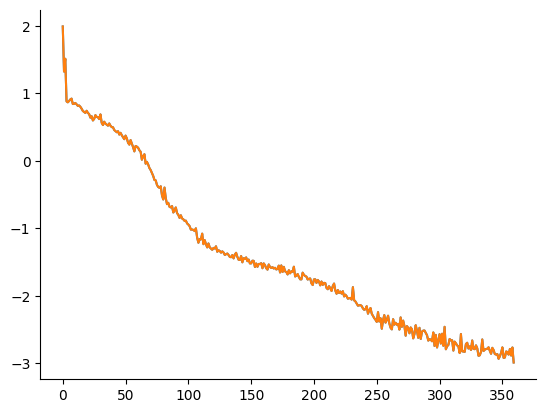

In [8]:
total_rmse=[]
houseids=[]

all_rmses = dict()
all_maes = dict() 
all_preds = dict() 

iteration_number = f'{start}_{end}_iterations'

print(f"STARTING FOR {appliance}, FOR ITERATIONS - {start} to {end}")

for i in range(start,end): #total 10 iterations

    print(f"############################################Random iteration number#################################### : {i+1}")

    train_houses = all_appliance_train_lists[appliance][0] 
    test_houses = all_appliance_test_lists[appliance][0] 
    pool_houses = all_appliance_pool_lists[appliance][0] 

    print(f"I am pool houses picck {pool_houses}")
    
    
    train = data_aggregated[data_aggregated["dataid"].isin(train_houses)] 
    test = data_aggregated[data_aggregated["dataid"].isin(test_houses)]

    all_rmses[i] = []
    all_maes[i] = []
    all_preds[i] = []
    
    houses=[]

    start= ["2018-03-01 00:00:00-06","2018-03-11 00:00:00-06","2018-03-16 00:00:00-06","2018-03-21 00:00:00-06","2018-03-26 00:00:00-06","2018-04-01 00:00:00-06", "2018-04-06 00:00:00-06", "2018-04-11 00:00:00-06", "2018-04-16 00:00:00-06", "2018-04-21 00:00:00-06"]
    end=   ["2018-03-10 23:59:00-06","2018-03-15 23:59:00-06","2018-03-20 23:59:00-06","2018-03-25 23:59:00-06","2018-03-31 23:59:00-06","2018-04-05 23:59:00-06", "2018-04-10 23:59:00-06", "2018-04-15 23:59:00-06", "2018-04-20 23:59:00-06", "2018-04-25 23:59:00-06"]
    
    for j in range(len(start)):
        
        
        print(f"-------------------------------------------Iteration No:----------------------------------------- -> {i}.{j}")

        if(j==0):
            rmsee, maes, train, test,current_pred = retrain_random(0, start[j], end[j], pool_houses, train, test,appliance, data_aggregated)
            all_rmses[i].append(rmsee.item())
            all_maes[i].append(maes.item())
            all_preds[i].append(current_pred)

            random_house_id = random_picks[appliance][i][j]
            print(f"I am random house id = {random_house_id}")
            print(f"I am pool houses {pool_houses}")
            print(f"{np.where(np.array(pool_houses)==random_house_id)}")
            print(f"{np.where(np.array(pool_houses)==random_house_id)[0]}")
            print(f"{np.where(np.array(pool_houses)==random_house_id)[0][0]}")
            random_house_index = np.where(np.array(pool_houses)==random_house_id)[0][0]  

            houses.append(random_house_id)
            pool_houses= np.delete(pool_houses, random_house_index)
            # break #REMOVE AT THE END

        elif(j==10):
            rmsee, maes, train, test,current_pred = retrain_random(random_house_id, start[j], end[j], pool_houses, train, test,appliance, data_aggregated)
            all_rmses[i].append(rmsee.item())
            all_maes[i].append(maes.item())
            all_preds[i].append(current_pred)

        else:
            rmsee, maes, train, test,current_pred = retrain_random(random_house_id, start[j], end[j], pool_houses, train, test,appliance, data_aggregated)
            all_rmses[i].append(rmsee.item())
            all_maes[i].append(maes.item())
            all_preds[i].append(current_pred)

            random_house_id = random_picks[appliance][i][j]
            
            random_house_index = np.where(np.array(pool_houses)==random_house_id)[0][0]  
            
            houses.append(random_house_id)
            pool_houses= np.delete(pool_houses, random_house_index)
        
        
    # total_rmse.append(rmse_iter)
    houseids.append(houses)
    
    # if i not in all_rmses:
    #     all_rmses[i] = total_rmse




In [9]:
name_of_file_rmses = "lr33lessbs4096random"+"_"+str(iteration_number) + "RMSES"+".csv"
name_of_file_maes = "lr33lessbs4096random"+"_"+str(iteration_number) + "MAES"+".csv"
# name_of_file_preds = str(random)+"_"+str(iteration_number)+"PREDS"+".csv"

if not os.path.exists(f'{appliance}'):
    os.mkdir(f'{appliance}')

# Save the DataFrame to a CSV file
pd.DataFrame(all_rmses).to_csv(os.path.join(f'{appliance}', f'{name_of_file_rmses}'), index=False)
pd.DataFrame(all_maes).to_csv(os.path.join(f'{appliance}', f'{name_of_file_maes}'), index=False)
# pd.DataFrame(all_preds).to_csv(os.path.join(f'{appliance}', f'{name_of_file_preds}'), index=False)